## Oil Price Analysis

#### Importing necessary libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import pmdarima as pm
from datetime import datetime
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.seasonal.sarim
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)

from scipy.signal import savgol_filter as smooth
import scipy.stats as stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


import tensorflow as tf
import mlflow

In [2]:
import warnings
warnings.filterwarnings('ignore', message="Could not infer format")

In [3]:
sys.path.append(os.path.abspath('../scripts'))
from Utils import DataUtils
from Plotting import Plots
from Logger import LOGGER
from timeseries_process import Timeseries, Utils
from Model_utils import ModelUtils

data_utils = DataUtils()
plots = Plots()
logger = LOGGER

time_utils = Utils()
timeseries = Timeseries()
model_utils = ModelUtils()

In [4]:
# Loading data
data = data_utils.load_data('BrentOilPrices.csv')

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data = data.set_index('Date')

# Preprocess the data
data['Price'] = data['Price'].interpolate()

2024-11-06 12:33 - DEBUG :: Loading data from file...


In [5]:
window = 7

df, m, b, ref = time_utils.read_data(csv_file = '../data/BrentOilPrices.csv', 
                              window = window)

df.head()

2024-11-06 12:33 - INFO :: Time range: from 20-05-1987 to 14-11-2022


,Price,detrended_log_price,smoothed_detrended_log_price_w7
Date,,,
1987-05-20,18.63,0.274162,0.270815
1987-05-21,18.45,0.264234,0.270128
1987-05-22,18.55,0.269420,0.269868
1987-05-25,18.60,0.271892,0.269973
1987-05-26,18.63,0.273285,0.270385


CV_arima/detrended_log_price_train_506_test_30_cv_5
Use 506 points to predict 30.


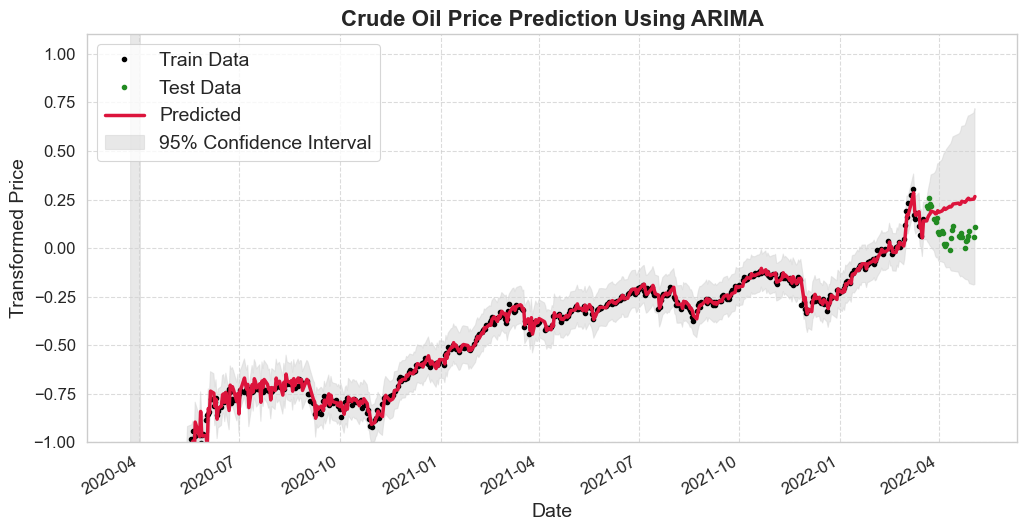

2024-11-06 12:36 - INFO :: Time range: from 20-05-1987 to 14-11-2022


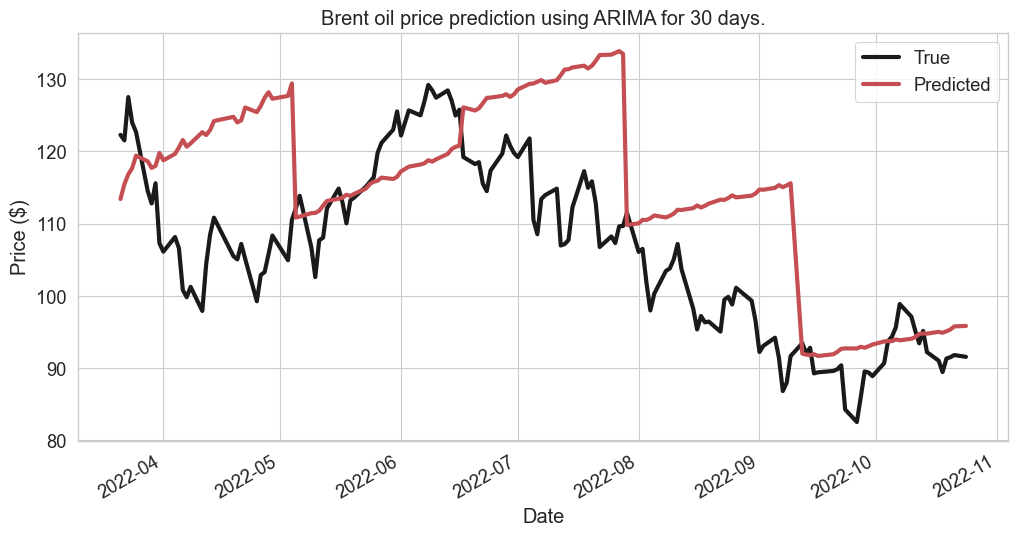

In [7]:
#number of CV slices
cv_num = 5
#253 trading days per year
n_inputs = 253 * 2
n_outputs = 30

# smooth target
target = 'detrended_log_price' 

#add exogenous variable
add_exog = False
exog_col = '' 

path = 'CV_arima'

df_metric, df_coeff, df_true_pred = timeseries.cv_arima(df, cv_num, n_inputs, n_outputs, path, 
                               target, params = (4,1,1), model_name = 'ARIMA',
                               add_exog = False)

**Interpretation**

- The predicted line and confidence intervals closely follow the general trend of the test data in the short term, indicating the model's effectiveness in capturing the underlying pattern.
- However, some deviations between the actual test data (green dots) and the predictions (red line) are visible, particularly where the test data slightly fluctuates. This is normal in time series forecasting, as no model can capture every minor variation.

**Summary:**
- The plot suggests that the ARIMA model captures the overall trend of crude oil prices well but may have some limitations in perfectly predicting short-term fluctuations. The confidence intervals provide a reasonable range around the predictions, indicating areas where the model has more uncertainty.

#### Build Regression model using Vanilla LSTM

#### Setting up mlflow

In [5]:
client, price_experiment = model_utils.setUp_mlflow()

2024-11-06 08:37 - INFO :: Setting up Mlflow
2024-11-06 08:37 - INFO :: Found existing experiment name: oil-price-Data-forecasting


In [6]:
# Feature enginnerring 
data = data_utils.add_features(data)
data.bfill(inplace=True)

In [ ]:
X = data.drop('Price', axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model1 = model_utils.train_neurals('LSTM',X_train, y_train, X_test,y_test)  

2024-11-06 08:41 - INFO :: Start training LSTM model...


2024-11-06 08:42 - INFO :: Training LSTM took 50.23 seconds


#### Evaluating LSTM model

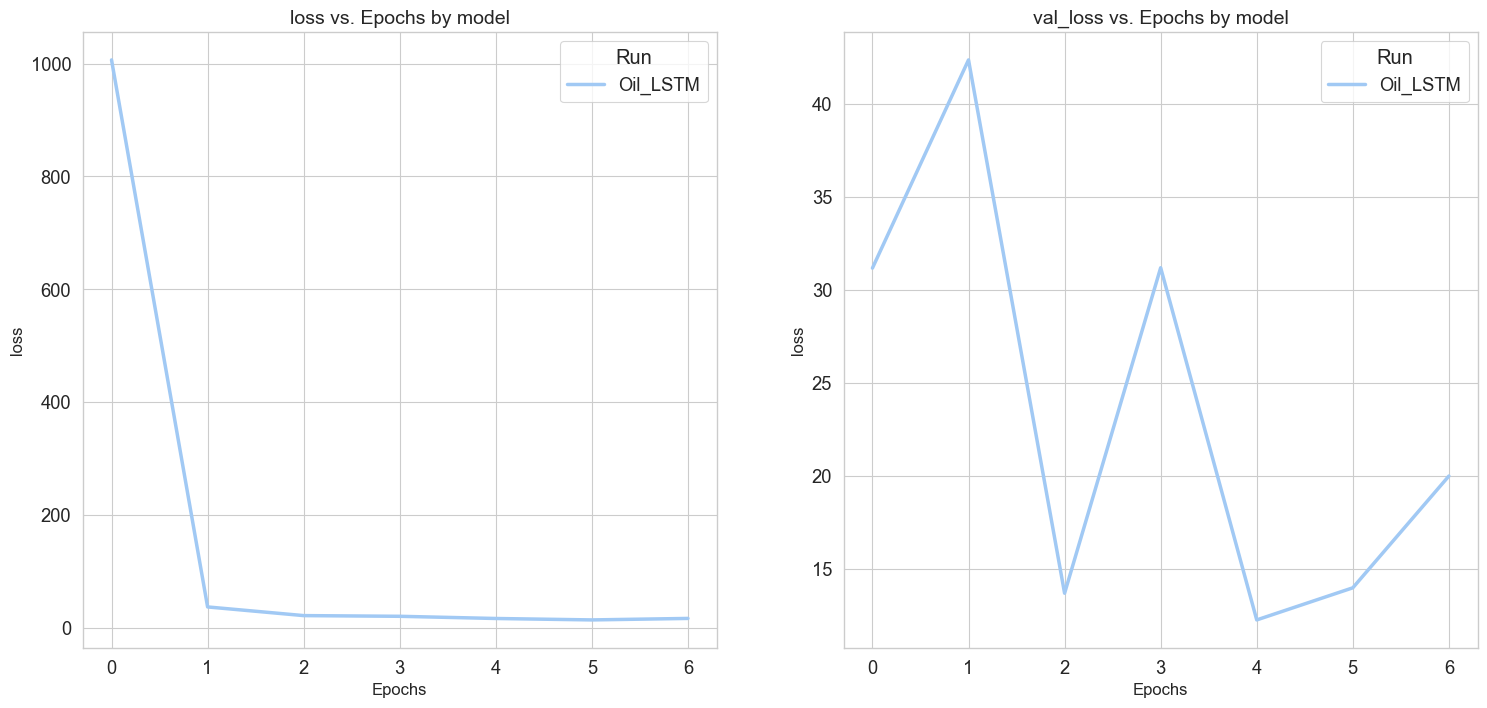

In [ ]:
model_utils.plot_evaluate_neurons('loss')

**Observation:**

- The training loss decreases rapidly in the initial epochs, indicating that the model is learning quickly.
    * However, the decrease slows down after a few epochs, suggesting that the model is approaching its optimal performance on the training data.


- The validation loss exhibits a more volatile behavior.
    * It initially decreases, but then starts to increase after a few epochs. This is a sign of overfitting, where the model is becoming too specialized to the training data and is unable to generalize well to new data.

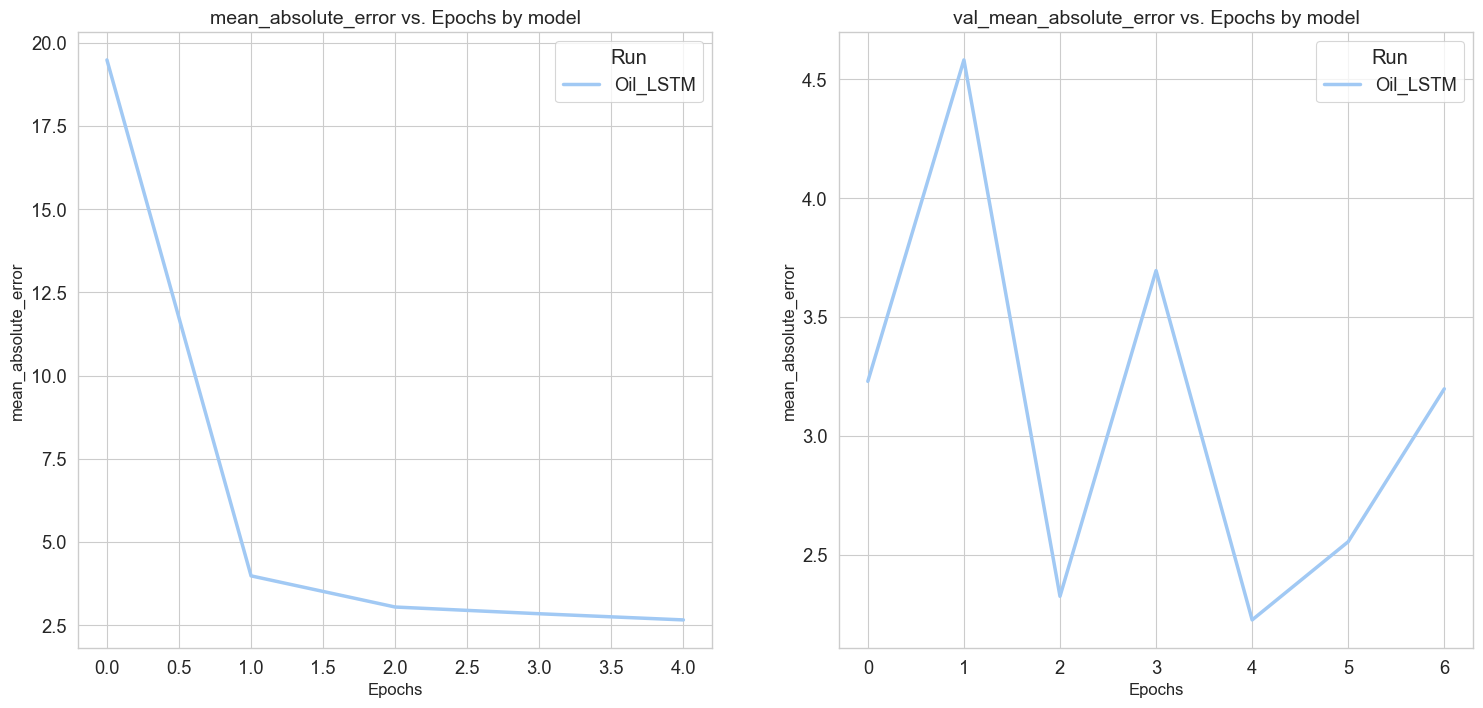

In [ ]:
model_utils.plot_evaluate_neurons('mean_absolute_error')

**Observation:**

- The training mean absolute error decreases rapidly in the initial epochs, indicating that the model is learning quickly.
    * However, the decrease slows down after a few epochs, suggesting that the model is approaching its optimal performance on the training data.


- The validation mean absolute error exhibits a more volatile behavior.
    * It initially decreases, but then starts to increase after a few epochs. This is a sign of overfitting, where the model is becoming too specialized to the training data and is unable to generalize well to new data.

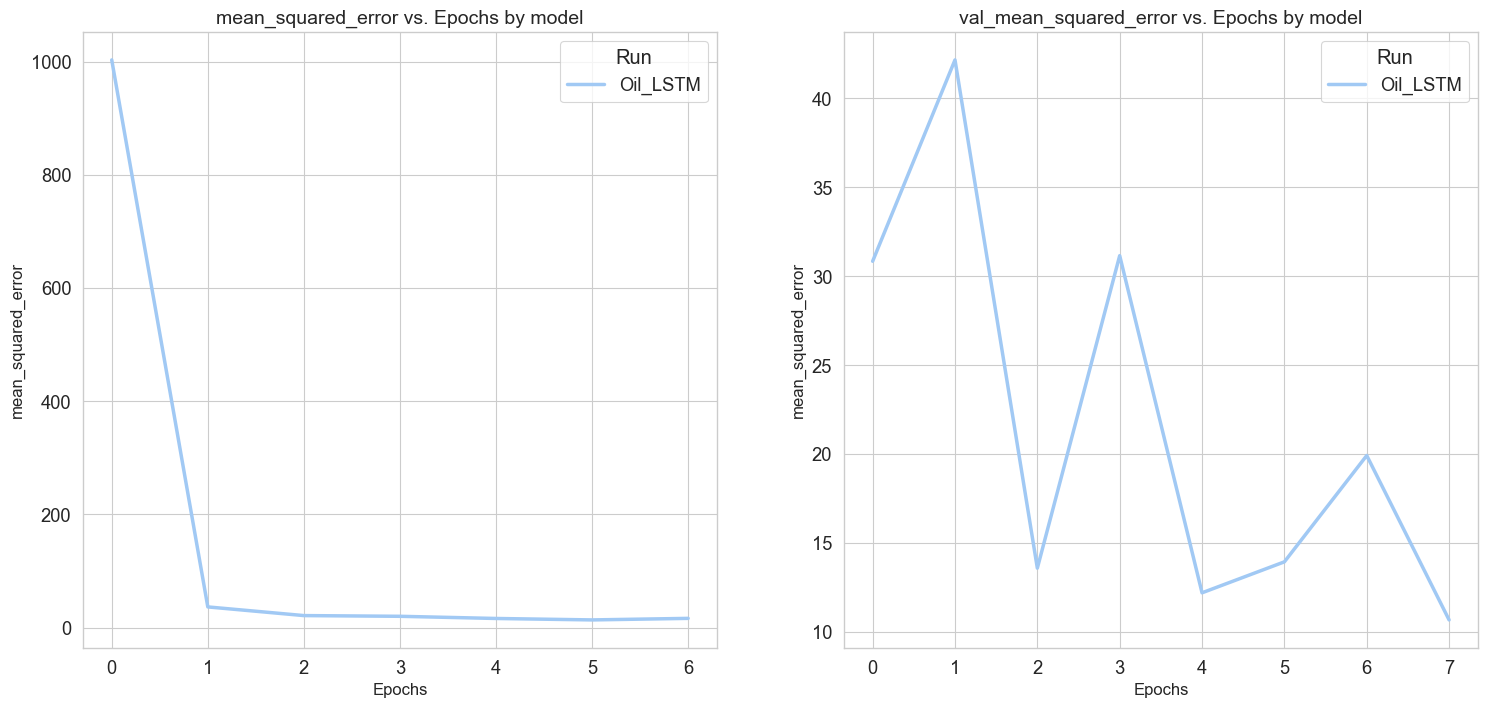

In [ ]:
model_utils.plot_evaluate_neurons('mean_squared_error')

**Observation:**

- The training mean squared error decreases rapidly in the initial epochs, indicating that the model is learning quickly.
    * However, the decrease slows down after a few epochs, suggesting that the model is approaching its optimal performance on the training data.


- The validation mean squared error exhibits a more volatile behavior.
    * It initially decreases, but then starts to increase after a few epochs. This is a sign of overfitting, where the model is becoming too specialized to the training data and is unable to generalize well to new data.

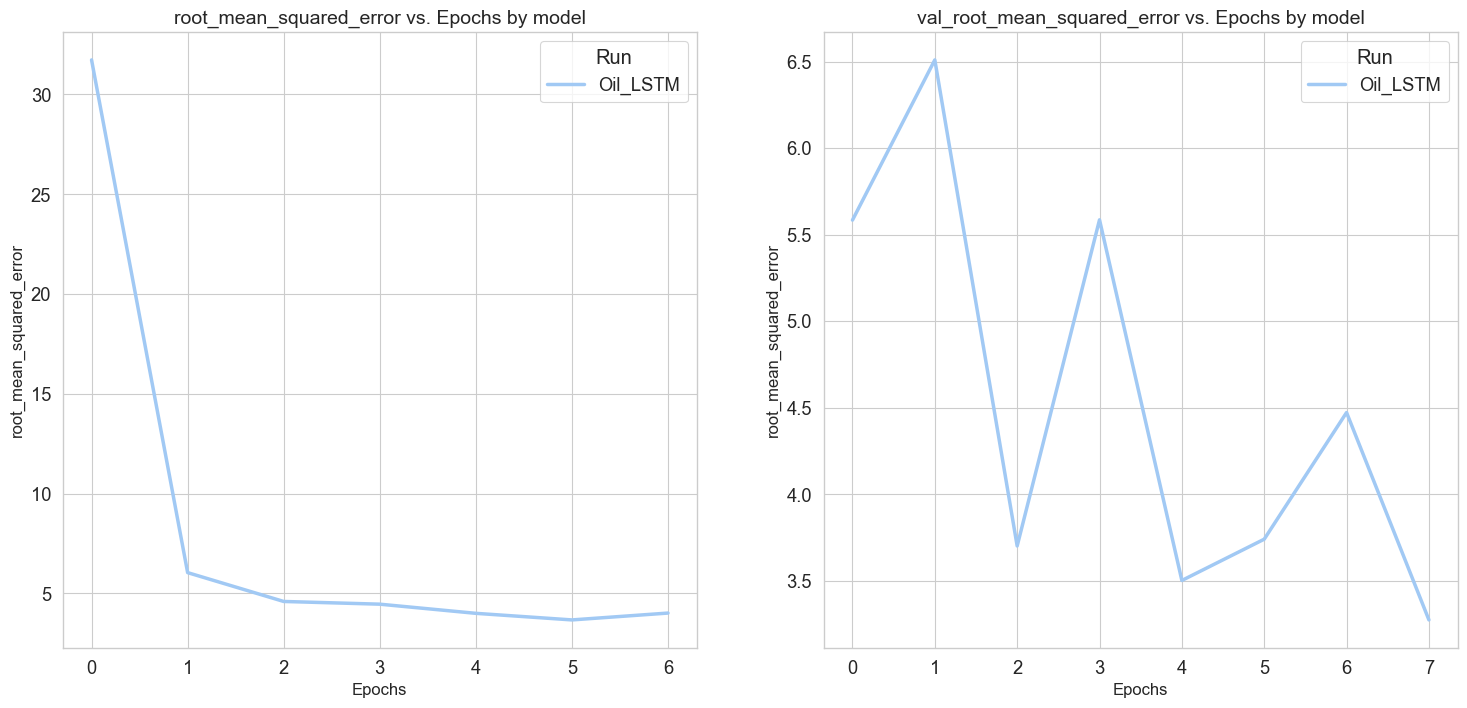

In [ ]:
model_utils.plot_evaluate_neurons('root_mean_squared_error')

**Observation:**

- The training RMSE decreases rapidly in the initial epochs, indicating that the model is learning quickly.
    * However, the decrease slows down after a few epochs, suggesting that the model is approaching its optimal performance on the training data.


- The validation RMSE exhibits a more volatile behavior.
    * It initially decreases, but then starts to increase after a few epochs. This is a sign of overfitting, where the model is becoming too specialized to the training data and is unable to generalize well to new data.